In [1]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import copy

In [2]:
with open("../Dane/Datasets/d50-resampled.pickle", "rb") as file:
    dataset=pickle.load(file)

In [20]:
with open("../Dane/Ecola-szeregi256", "rb") as file:
    dataset=pickle.load(file)
    dataset=torch.Tensor(dataset.reshape(*dataset.shape,1))

In [20]:
class DilatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dilation, last_state_only=False, ifCuda=True):
        super().__init__()
        self.hidden_size=hidden_size
        self.dilation=dilation
        self.last_state_only=last_state_only
        self.ifCuda=ifCuda
        
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True)
    
    def forward(self, X, H=None):
        assert X.shape[1]%self.dilation==0, "Wrong second dimension length"
        batchSize=X.shape[0]
        seqLength=X.shape[1]

        if self.last_state_only:
            L=[X[:,self.dilation-1::self.dilation,:]]
        else:
            L=[X[:,i::self.dilation,:] for i in range(self.dilation)]
        X=torch.cat(L,0)
        if H is None:
            out,(hid,_)=self.lstm(X)
        else:
            #assert H.shape[0]==0
            #H.reshape(H.shape[1:])
            H=torch.cat([H for i in range(self.dilation)],1)
            
            C=torch.zeros_like(H)
            out,(hid,_)=self.lstm(X,(H,C))
        if self.ifCuda:
            X=torch.zeros((batchSize, seqLength, self.hidden_size), device="cuda")
        else:
            X=torch.zeros((batchSize, seqLength, self.hidden_size))
        if self.last_state_only:
            X[:,self.dilation-1::self.dilation,:]=out
        else:
            for i in range(self.dilation):
                X[:,i::self.dilation,:]=out[i*batchSize:(i+1)*batchSize,:,:]
        
        return X, hid.reshape(hid.shape[1:])

In [21]:
class Enkoder(nn.Module):
    def __init__(self, ifCuda=True):
        super().__init__()
        self.L1=DilatedRNN(input_size=1, hidden_size=8, dilation=1, last_state_only=True, ifCuda=ifCuda)
        self.L2=DilatedRNN(input_size=8, hidden_size=8, dilation=4, last_state_only=True, ifCuda=ifCuda)
        self.L3=DilatedRNN(input_size=8, hidden_size=8, dilation=16, last_state_only=True, ifCuda=ifCuda)
        self.L4=DilatedRNN(input_size=8, hidden_size=8, dilation=64, last_state_only=True, ifCuda=ifCuda)
        
        self.prosta=nn.Sequential(
            nn.Linear(in_features=32, out_features=128),
            nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32)
        )

    def forward(self, X):
        batchSize=X.shape[0]
        X,h1=self.L1(X)
        X,h2=self.L2(X)
        X,h3=self.L3(X)
        _,h4=self.L4(X)
        return self.prosta(torch.cat((h1,h2,h3,h4),1))

In [22]:
class Dekoder(nn.Module):
    def __init__(self, hidden_size, ifCuda=True):
        super().__init__()
        self.ifCuda=ifCuda
        self.L4=DilatedRNN(input_size=32, hidden_size=16, dilation=1, ifCuda=ifCuda)
        self.L3=DilatedRNN(input_size=40, hidden_size=32, dilation=4, ifCuda=ifCuda)
        self.L2=DilatedRNN(input_size=hidden_size, hidden_size=40, dilation=16, ifCuda=ifCuda)
        self.L1=DilatedRNN(input_size=1, hidden_size=hidden_size, dilation=64, ifCuda=ifCuda)
        
        self.sequential1=nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size*4),
            nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size*4, out_features=hidden_size)           
        )
        
        self.sequential=nn.Sequential(
            nn.Linear(in_features=16, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )

    
    def forward(self, hid, generatedLength=256):
        hid=self.sequential1(hid)
        batchSize=hid.shape[0]
        hid=hid.reshape((1,*hid.shape))
        if self.ifCuda:
            zera=torch.zeros((batchSize, generatedLength,1),device="cuda")
        else:
            zera=torch.zeros((batchSize, generatedLength,1))
        
        out,_=self.L1(zera,hid)
        out,_=self.L2(out)
        out,_=self.L3(out)
        out,_=self.L4(out)
        out=self.sequential(out)
        return out

In [37]:
class DTCR(nn.Module):
    """Choć póki co to dosyć szumna nazwa jak na aktualny stan implementacji."""
    def __init__(self, ifCuda=True):
        super().__init__()
        self.enkoder=Enkoder(ifCuda=ifCuda)
        self.dekoder=Dekoder(32, ifCuda=ifCuda)

    def forward(self, X):
        hid=self.enkoder(X)
        out=self.dekoder(hid, generatedLength=X.shape[1])
        return hid,out

In [24]:
def zakodujDane(dataset, model, batch_size=256, ifCuda=True):
    data=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
    if ifCuda:
        model=model.to("cuda")
        L=[model.enkoder(batch.to("cuda")) for batch in data]
    else:
        L=[model.enkoder(batch) for batch in data]
    return torch.cat(L,0)

def wygladzDane(dataset, model, batch_size=256, ifCuda=True):
    data=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
    if ifCuda:
        model=model.to("cuda")
        L=[model(batch.to("cuda"))[0] for batch in data]
    else:
        L=[model(batch)[0] for batch in data]
    return torch.cat(L,0)

In [25]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50):
    kosztOdtwarzania=nn.MSELoss()
    seqLength=256
    def evalBatch(batch):
        if ifCuda:
            batch=batch.to("cuda")
        _,resultPrawdziwe=model(batch[:,:seqLength,:])
        scoreOdtwarzania=kosztOdtwarzania(resultPrawdziwe,batch[:,:seqLength,:])*100
        return scoreOdtwarzania
    
    if ifCuda:
        model=model.to("cuda")
    
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    historia=[]
    
    data_validation=torch.utils.data.DataLoader(validationset,batch_size=batch_size,drop_last=True)
    data_train=torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True,drop_last=True)

    try:    
        for epoch in range(epoch_count):
            #Training
            for batch in data_train:
                iter_counter+=1
                optimizer.zero_grad()
                score=evalBatch(batch)
                score.backward()
                optimizer.step()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | loss {1: >9.7f}".format(
                        iter_counter,score.item()))
            #Validation
            validationScore=0
            with torch.no_grad():
                for batch in data_validation:
                    wyn=evalBatch(batch)
                    validationScore+=wyn
            validationBatches=validationset.shape[0]//batch_size
            avgValidationScore=validationScore/validationBatches

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "Epoch {0: >2} | valid: {1: >6.5f} | best valid: {2: >6.5f} | best epoch {3: >2}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch
            )
            historia.append(avgValidationScore)
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
            print("Sleeping to cool GPU.")
            time.sleep(5)
    except KeyboardInterrupt:
        pass
    return historia

In [38]:
model=DTCR(ifCuda=True)

In [27]:
podzial=165000
#trainset=dataset[:10000,:,:]
trainset=dataset[:podzial,:,:]
testset=dataset[podzial:,:,:]
print(trainset.min(),trainset.max())
testset=(testset-trainset.min())/(trainset.max()-trainset.min())
trainset=(trainset-trainset.min())/(trainset.max()-trainset.min())

tensor(0.0018) tensor(0.0713)


In [31]:
W=uczModel(model, trainset,testset, batch_size=1024, 
           log_every=20, lr=0.003, epoch_count=100,
           ifCuda=True)

---------------------------------------------------------------
Epoch 38 | valid: 0.04037 | best valid: 0.04037 | best epoch 38
---------------------------------------------------------------
Sleeping to cool GPU.
Minibatch   6280  | loss 0.0449332
Minibatch   6300  | loss 0.0455585
Minibatch   6320  | loss 0.0463385
Minibatch   6340  | loss 0.0460449
Minibatch   6360  | loss 0.0440409
Minibatch   6380  | loss 0.0458084


In [ ]:
wyniki=np.concatenate([wyniki, np.array(W)])

In [32]:
wyniki=np.array(W).copy()

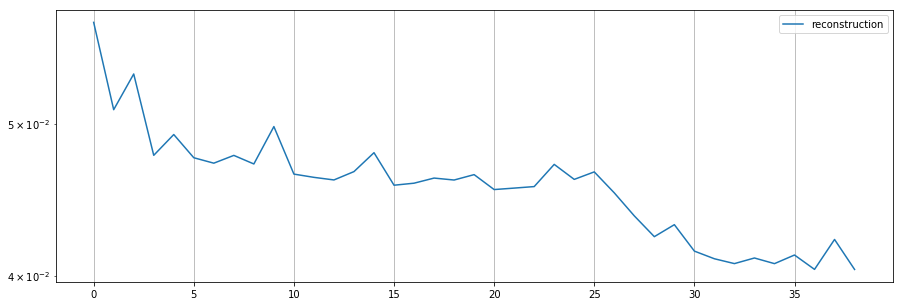

In [33]:
pocz=0
kon=200
plt.gcf().set_size_inches((15,5))
plt.grid(True)
plt.plot(wyniki,label="reconstruction")

#plt.ylim(0.01,1)
plt.yscale("log")
plt.legend()

# Analiza

In [30]:
model.load_state_dict(torch.load("../Modele/kodowanie1-DTCR-8-8-8-8-naprKmeans-1624101630.9567149.pth"))

<All keys matched successfully>

In [42]:
model.to("cuda")
szereg=testset[:4,:,:].to("cuda")
_,X=model(szereg)

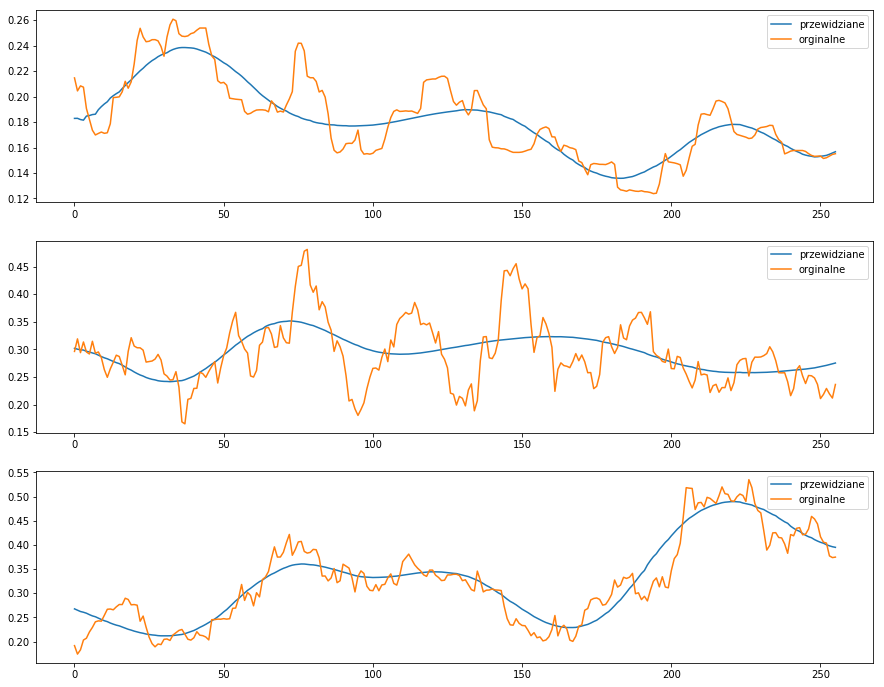

In [43]:
plt.gcf().set_size_inches((15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.array(X[i,:,:].cpu().detach()), label="przewidziane")
    plt.plot(np.array(szereg[i,:,:].cpu()), label="orginalne")
    plt.legend()

# Grupowanie

In [82]:
model.load_state_dict(torch.load("../Modele/DTCR-8-8-8-8-rekon.pth"))

<All keys matched successfully>

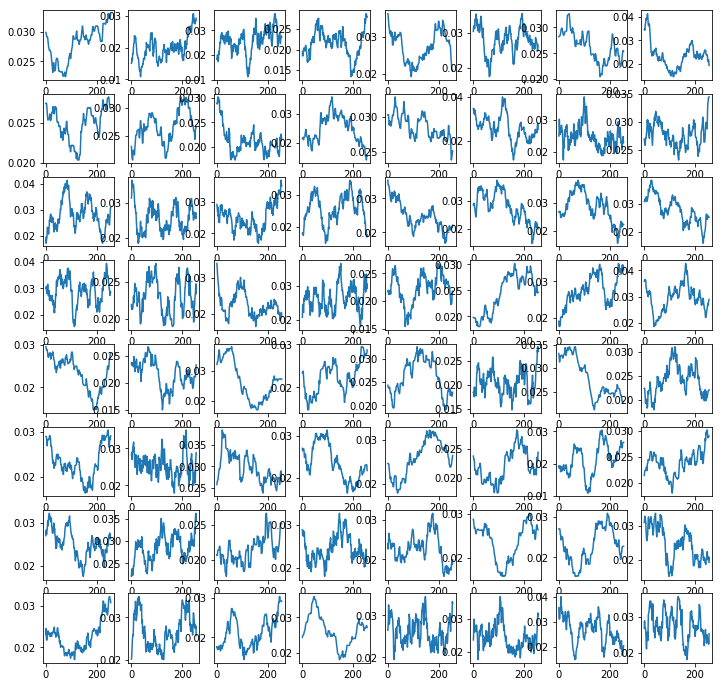

In [83]:
plt.gcf().set_size_inches((12,12))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.plot(np.array(dataset[i,:,:].cpu()))
plt.show()

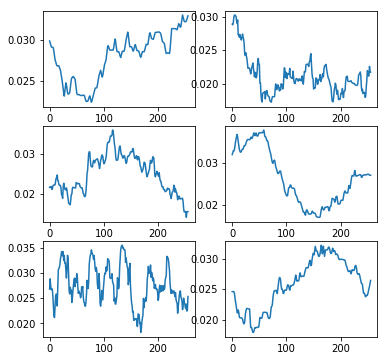

In [84]:
plt.gcf().set_size_inches((6,6))
for j,i in enumerate([0,10,11,34,63,44]):
    plt.subplot(3,2,j+1)
    plt.plot(np.array(dataset[i,:,:].cpu()))
plt.show()

In [85]:
centra=torch.Tensor(dataset[[0,10,11,34,63,44],:,:]).to("cuda")
with torch.no_grad():
    centra, _ = model(centra)
centra.requires_grad_(True)

centra.shape

torch.Size([6, 32])

In [86]:
def uczDecFT(model, dataset, validationset, centers, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50, k=6, KLLambdas={0:100}):
    seqLength=256
    
    funkcjaKosztuOdtwarzania=nn.MSELoss()
    
    def evalBatch(batch):
        if ifCuda:
            batch=batch.to("cuda")
        hid, out = model(batch)
        euklidesPlus=torch.sum((hid.reshape(hid.shape[0],1,hid.shape[1])-centers.reshape(1,*centers.shape))**2, 
                           dim=-1)+1
        odwEukPlus=1/euklidesPlus
        sumaPodobienstw=torch.sum(odwEukPlus, dim=-1, keepdim=True)
        q=odwEukPlus/sumaPodobienstw
        
        f_j=torch.sum(q, dim=0, keepdim=True)
        norm_q_kwd=q**2/f_j
        suma_norm_q_kwd=torch.sum(norm_q_kwd, dim=-1, keepdim=True)
        p=norm_q_kwd/suma_norm_q_kwd
        
        kosztKL=torch.sum(torch.log(p/q)*p)*KLLambda
        kosztOdtw=funkcjaKosztuOdtwarzania(batch, out)*100
        
        koszt=kosztKL+kosztOdtw
        
        return koszt, (kosztKL, kosztOdtw)
    
    print(KLLambdas)
    
    if ifCuda:
        model=model.to("cuda")

    if not centers.requires_grad:
        raise RuntimeError("Centers should requires grad.")
        
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    historia=[]
    
    data_validation=torch.utils.data.DataLoader(validationset,batch_size=batch_size,drop_last=True)
    data_train=torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True,drop_last=True)
    
    try:    
        for epoch in range(epoch_count):
            if epoch in KLLambdas:
                KLLambda=KLLambdas[epoch]
            #Training
            for batch in data_train:
                iter_counter+=1
                optimizer.zero_grad()
                score,scoreSzczegolowy=evalBatch(batch)
                score.backward()
                optimizer.step()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | loss {1: >9.7f} | {2: >6.5f} {3: >6.5f}".format(
                        iter_counter,score.item(), scoreSzczegolowy[0].item(),
                        scoreSzczegolowy[1].item()))
            #Validation
            validationScore=0
            reconstructionScore=0
            kmeansScore=0
            with torch.no_grad():
                for batch in data_validation:
                    wyn=evalBatch(batch)
                    validationScore+=wyn[0]
                    reconstructionScore+=wyn[1][1]
                    kmeansScore+=wyn[1][0]
            validationBatches=validationset.shape[0]//batch_size
            avgValidationScore=validationScore/validationBatches
            avgRecScore=reconstructionScore/validationBatches
            avgKmeansScore=kmeansScore/validationBatches

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            #print(avgClasScore)
            #print(avgKmeansScore)
            m = "Epoch {0: >2} | valid: {1: >6.5f} | best valid: {2: >6.5f} | best epoch {3: >2} | kmeans: {4: >6.5f} | rec: {5: >6.5f}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch,avgKmeansScore, avgRecScore
            )
            historia.append((avgKmeansScore,avgRecScore))
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
            print("Sleeping to cool GPU.")
            time.sleep(5)
    except KeyboardInterrupt:
        pass
    return historia

In [87]:
W=uczDecFT(model, trainset,testset,centra, batch_size=1024, 
           log_every=20, lr=0.003, epoch_count=20,
           ifCuda=True, KLLambdas={0:100, 1:200, 2:400, 3:750, **dict([(i, (i-3)*1000) for i in range(4,14)])})

------------------------------------------------------------------------------------------------
Epoch 19 | valid: 0.16650 | best valid: 0.04712 | best epoch  0 | kmeans: 0.12419 | rec: 0.04231
------------------------------------------------------------------------------------------------
Sleeping to cool GPU.


In [88]:
torch.save(model.state_dict(), "../Modele/DTCR-8-8-8-8-rekon-po-fineTunningu.pth")

## Transformacja wszystkich danych

In [34]:
with open("../Dane/Datasets/d50-resampled.pickle", "rb") as file:
    dataset=pickle.load(file)

In [26]:
datasetTransf=(dataset-0.0018)/(0.0713-0.0018)

In [27]:
zak=zakodujDane(datasetTransf, model)

In [28]:
zak.shape

torch.Size([4081, 32])

In [ ]:
with open("P")

In [23]:
with torch.no_grad():
    zakodowane=wygladzDane(datasetTransf, model)

In [24]:
zakodowane=zakodowane*(0.0713-0.0018)+0.0018

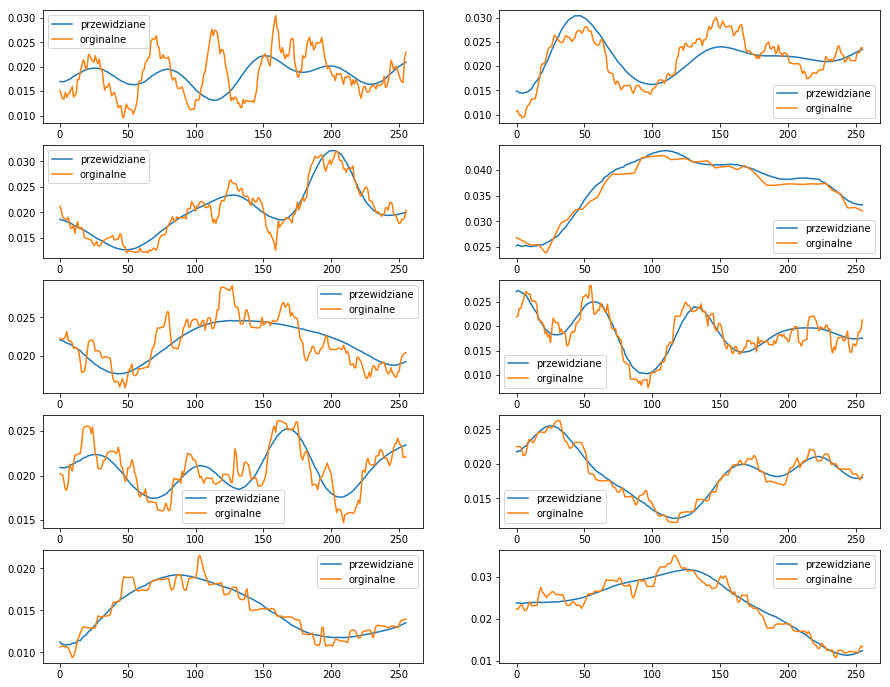

In [25]:
plt.gcf().set_size_inches((15,12))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.array(zakodowane[i,:,:].cpu().detach()), label="przewidziane")
    plt.plot(np.array(dataset[i,:,:].cpu()), label="orginalne")
    plt.legend()

In [45]:
zakodowane=np.array(zakodowane.cpu()).reshape(zakodowane.shape[:2])

In [46]:
zakodowane.shape

(171988, 256)

In [47]:
with open("../Dane/Datasets/d50-wygladzone.pickle", "wb") as file:
    pickle.dump(zakodowane, file)

In [57]:
zakodowaneStand=(zakodowane-zakodowane.mean(axis=1,keepdims=True))/zakodowane.std(axis=1, keepdims=True)

In [58]:
with open("../Dane/Datasets/d50-wygladzone-ustandaryzowane.pickle", "wb") as file:
    pickle.dump(zakodowaneStand, file)